
# Лабораторна робота №3  
**Тема:** Множинна лінійна регресія для оцінювання метрик програмного забезпечення  


## Мета роботи
Набути практичних навичок побудови множинного лінійного рівняння регресії для оцінювання метрик програмного забезпечення (ПЗ), перевірки мультиколінеарності, якості моделі (R², MMRE, PRED(0.25)), аналізу залишків і перевірок статистичних припущень.


In [1]:

# Імпорти та налаштування
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from scipy import stats

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

print("Імпорти готові.")


Імпорти готові.


## 1) Дані (завжди синтетичні, CSV користувача не читаємо)

In [4]:

# Генеруємо синтетичний набір метрик ПЗ
rng = np.random.default_rng(42)
N = 300

LOC     = rng.normal(800, 250, size=N).clip(50, None)
NOM     = rng.normal(20, 7, size=N).clip(1, None)
CC      = rng.normal(12, 5, size=N).clip(1, None)
FanIn   = rng.normal(4, 2, size=N).clip(0, None)
FanOut  = (FanIn + rng.normal(0, 1.2, size=N)).clip(0, None)
Churn   = rng.normal(100, 60, size=N).clip(0, None)
Age     = rng.normal(18, 8, size=N).clip(1, None)

noise = rng.normal(0, 2.0, size=N)
Defects = (
    0.0035*LOC +
    0.06*NOM +
    0.07*CC +
    0.10*FanOut +
    0.015*Churn +
    0.02*Age +
    1.2 + noise
)

df = pd.DataFrame({
    "LOC": LOC, "NOM": NOM, "CC": CC, "FanIn": FanIn, "FanOut": FanOut,
    "Churn": Churn, "Age": Age, "Defects": Defects
})

df_path = "software_metrics_synthetic.csv"
df.to_csv(df_path, index=False)
print("Збережено датасет:", df_path)
df.head()


Збережено датасет: software_metrics_synthetic.csv


,LOC,NOM,CC,FanIn,FanOut,Churn,Age,Defects
0,876.179270,32.091451,14.577052,4.779383,3.192334,66.022305,17.682350,9.389041
1,540.003973,9.262970,9.112306,4.205106,3.621673,62.523796,21.539637,2.585499
2,987.612799,26.046796,18.372236,3.705115,4.209387,179.508804,15.564586,9.502733
3,1035.141179,17.700323,8.862062,7.176552,7.053676,119.817397,14.722809,10.846191
4,312.241203,19.570730,8.816924,2.755585,1.974909,87.295972,18.738832,5.406626


## 2) Перевірка мультиколінеарності (VIF) та відсікання факторів

In [5]:

# Ціль і фактори
y = df["Defects"]
X = df.drop(columns=["Defects"]).copy()

# Функція VIF
def compute_vif(design: pd.DataFrame) -> pd.DataFrame:
    out = []
    for i, col in enumerate(design.columns):
        out.append((col, variance_inflation_factor(design.values, i)))
    return pd.DataFrame(out, columns=["feature","VIF"]).sort_values("VIF", ascending=False)

# Стандартизація для стабільного VIF
Xs = (X - X.mean())/X.std(ddof=0)
Xs = Xs.fillna(0.0)

vif_table = compute_vif(Xs)
display(vif_table)

# Відсікаємо фактори з VIF > 10
THRESH = 10.0
for _ in range(10):
    worst = vif_table.iloc[0]
    if worst["VIF"] <= THRESH:
        break
    Xs = Xs.drop(columns=[worst["feature"]])
    X  = X.drop(columns=[worst["feature"]])
    vif_table = compute_vif(Xs)

print("Фінальний перелік факторів:", list(X.columns))
vif_final = compute_vif(((X - X.mean())/X.std(ddof=0)).fillna(0.0))
vif_final


,feature,VIF
3,FanIn,3.124337
4,FanOut,3.102828
2,CC,1.034239
1,NOM,1.029849
6,Age,1.013926
0,LOC,1.009394
5,Churn,1.003457


Фінальний перелік факторів: ['LOC', 'NOM', 'CC', 'FanIn', 'FanOut', 'Churn', 'Age']


,feature,VIF
3,FanIn,3.124337
4,FanOut,3.102828
2,CC,1.034239
1,NOM,1.029849
6,Age,1.013926
0,LOC,1.009394
5,Churn,1.003457


## 3) Оцінка параметрів (OLS), T-тести, F-тест

In [6]:

X_sm = sm.add_constant(X)
ols = sm.OLS(y, X_sm).fit()
display(ols.summary())

lin = LinearRegression().fit(X, y)
y_hat = lin.predict(X)

print("F-тест значущості моделі: F =", round(ols.fvalue, 3), ", p =", f"{ols.f_pvalue:.3g}")


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Defects   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     13.65
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           2.86e-15
Time:                        04:02:32   Log-Likelihood:                -637.58
No. Observations:                 300   AIC:                             1291.
Df Residuals:                     292   BIC:                             1321.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2967      0.761      3.018      0.003       0.799       3.794
LOC            0.0034      0.001      6.547      0.000       0.002       0.004
NOM            0.0458      0.017      2.697      0.007       0.012       0.079
CC             0.0604      0.024      2.505      0.013       0.013       0.108
FanIn         -0.0739      0.111     -0.666      0.506      -0.292       0.145
FanOut         0.0496      0.097      0.511      0.609      -0.141       0.240
Churn          0.0126      0.002      6.190      0.000       0.009       0.017
Age            0.0329      0.016      2.096      0.037       0.002       0.064
==============================================================================
Omnibus:                        2.270   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                2.254
Skew:                          -0.034   Prob(JB):                        0.324
Kurtosis:                       3.419   Cond. No.                     5.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

F-тест значущості моделі: F = 13.649 , p = 2.86e-15


## 4) Метрики якості: R², Adjusted R², MMRE, PRED(0.25)

In [7]:

R2 = r2_score(y, y_hat)
n, k = X.shape
adj_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)

resid = y - y_hat
with np.errstate(divide='ignore', invalid='ignore'):
    MRE = np.abs(resid) / np.where(y != 0, np.abs(y), np.nan)
MMRE = np.nanmean(MRE)
PRED025 = np.nanmean((MRE <= 0.25).astype(float)) * 100.0

print("R^2:", round(R2, 4))
print("Adjusted R^2:", round(adj_R2, 4))
print("MMRE:", round(MMRE, 4))
print("PRED(0.25):", f"{PRED025:.2f}%")


R^2: 0.2465
Adjusted R^2: 0.2285
MMRE: 0.2494
PRED(0.25): 74.00%


## 5) Перевірка припущень: нормальність і гетероскедастичність

In [8]:

# Нормальність залишків
k2_stat, k2_p = stats.normaltest(resid)
sw_stat, sw_p = stats.shapiro(resid)

# Гетероскедастичність
bp_stat, bp_p, _, _ = het_breuschpagan(resid, X_sm)

print("D’Agostino K^2: stat =", round(k2_stat,3), ", p =", f"{k2_p:.3g}")
print("Shapiro–Wilk:   stat =", round(sw_stat,3), ", p =", f"{sw_p:.3g}")
print("Breusch–Pagan:  stat =", round(bp_stat,3), ", p =", f"{bp_p:.3g}")


D’Agostino K^2: stat = 2.27 , p = 0.321
Shapiro–Wilk:   stat = 0.993 , p = 0.177
Breusch–Pagan:  stat = 4.467 , p = 0.725


## 6) Візуалізація залишків

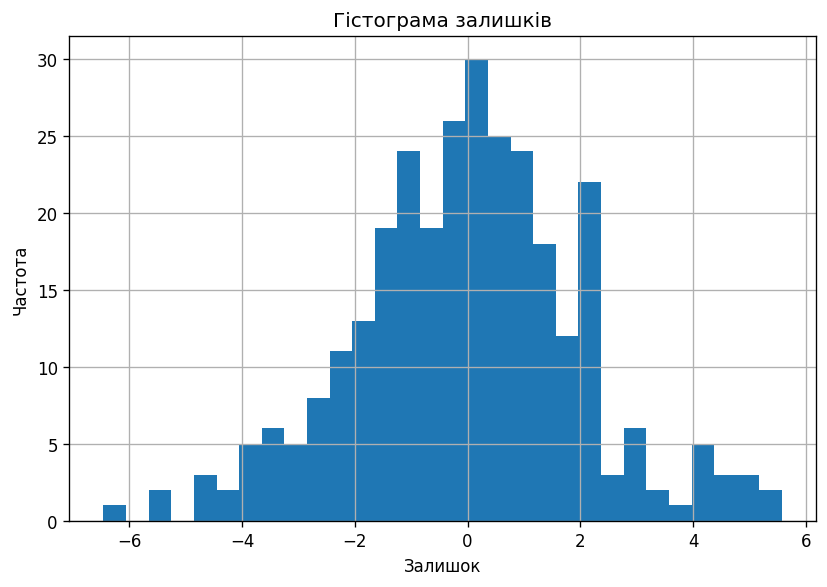

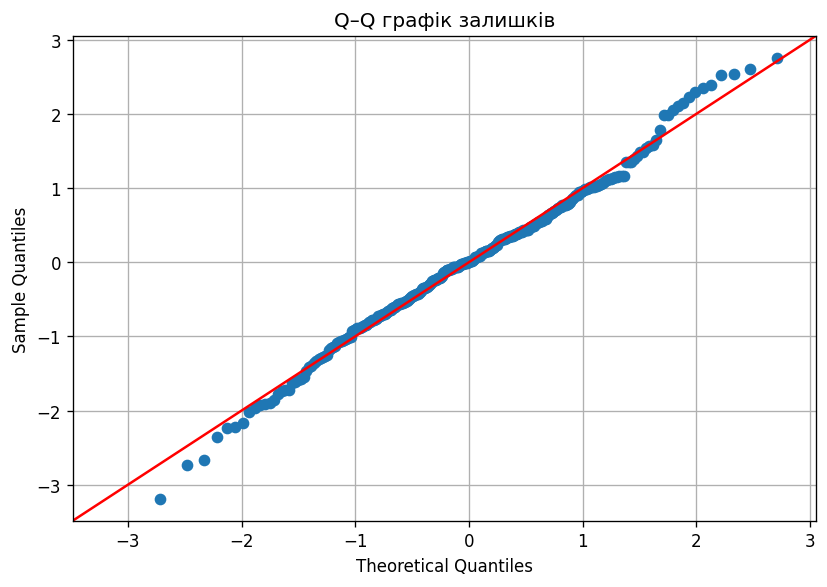

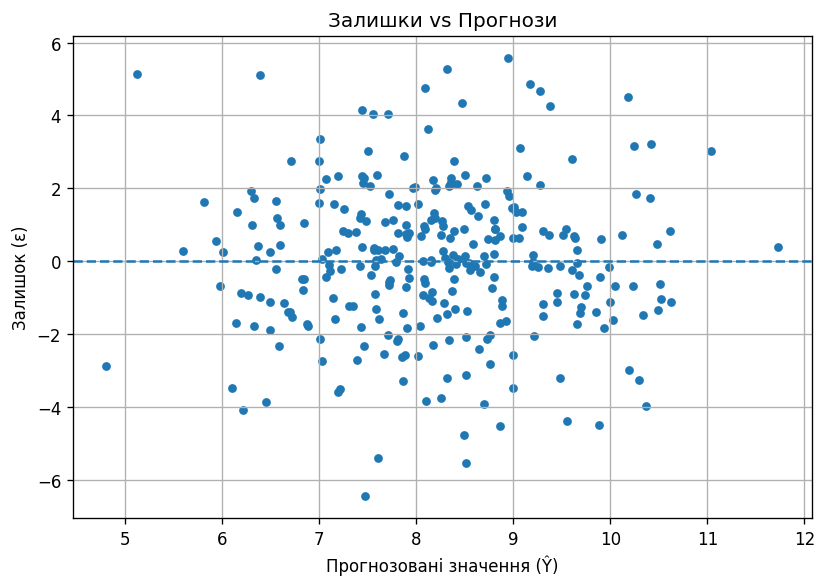

In [9]:

plt.figure()
plt.hist(resid, bins=30)
plt.title("Гістограма залишків")
plt.xlabel("Залишок")
plt.ylabel("Частота")
plt.tight_layout()
plt.show()

fig = sm.qqplot(resid, line='45', fit=True)
plt.title("Q–Q графік залишків")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_hat, resid, s=18)
plt.axhline(0, linestyle="--")
plt.title("Залишки vs Прогнози")
plt.xlabel("Прогнозовані значення (Ŷ)")
plt.ylabel("Залишок (ε)")
plt.tight_layout()
plt.show()



## 7) Висновки
- Модель множинної лінійної регресії побудована для цільової змінної **Defects** за фінальним набором факторів (після VIF-відсікання).  
- Значущість моделі підтверджується F-тестом; значущість коефіцієнтів — T-тестами (див. `summary()`).  
- Якість моделі оцінено показниками R², Adjusted R², MMRE, PRED(0.25).  
- Перевірено припущення про нормальність та однорідність дисперсії залишків.  
- За потреби — можливі поліпшення (лог-/Box-Cox-трансформації, робастні підходи, видалення викидів, регуляризація).
